# PROSPERINVENT

This notebook transforms the explicit temporal information in the dynamic inventory database into several databases with implicit temporal information.
It calculates the demand on infrastructure and creates databases accordingly.
It calculates the dynamic inventory and saves it in an excel file.
It calculates the static impact assessment.

environment: premise2

# Projekt

Bus production, bus transport and infrastructure

In [1]:
dorig = 'bustransA'
dinfra = 'businfraA'
dfleet = 'busprodA'

In [2]:
dorig = 'bustransB'
dinfra = 'businfraB'
dfleet = 'busprodB'

In [3]:
dnov = dorig
dinov = dinfra
dflnov = dfleet

In [4]:
dpres = 'pres_bg_bustrans'

In [5]:
fuorig = 'passenger transport'

In [6]:
fuIS = 'bus infrastructure'

In [7]:
fufl = 'bus fleet production'

bw2data & bw2io

In [8]:
import bw2data as bd 
import bw2io as bi
import bw2calc as bc

import bw2analyzer and pandas

In [9]:
import bw2analyzer as ba

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
bd.projects.set_current('ecoinvent_391_6')

In [ ]:
list(bd.databases)

In [13]:
len(bd.databases)

2878

In [14]:
bdat = 'ecoinvent_391_6'

In [15]:
preinv = 'ecoinvent_cutoff_3.9_remind_SSP2-PkBudg1150_'

In [16]:
bs = bd.Database('biosphere3')

In [17]:
import numpy as np

In [18]:
# This class is copied from bw_temporalis 

import numpy.typing as npt

class TemporalDistribution:

    def __init__(
              self, date: npt.NDArray[np.datetime64 | np.timedelta64], amount: npt.NDArray
        ):
            datetime_type = np.dtype("datetime64[s]")
            timedelta_type = np.dtype("timedelta64[s]")
            if not isinstance(date, np.ndarray) or not isinstance(amount, np.ndarray):
                raise ValueError("Invalid input types")
            elif not date.shape == amount.shape:
                raise ValueError("Shapes of input `date` and `amount` not identical")
            elif not (
                np.issubdtype(date.dtype, np.datetime64)
                or np.issubdtype(date.dtype, np.timedelta64)
            ):
                raise ValueError(f"Incorrect `date` dtype ({date.dtype})")
            elif not len(date):
                raise ValueError("Empty array")

            # Conversion needed for `temporal_convolution` functions
            self.amount = amount.astype(np.float64)

            if np.issubdtype(date.dtype, np.datetime64):
               self.date = date.astype(datetime_type)
               self.base_time_type = datetime_type
            elif np.issubdtype(date.dtype, np.timedelta64):
               self.date = date.astype(timedelta_type)
               self.base_time_type = timedelta_type
            else:
               raise ValueError("`date` must be numpy datetime or timedelta array")
    
    @property
    def total(self) -> float:
        return float(self.amount.sum())

In [19]:
#-------------------------------------
# Time span of the calculation
#-------------------------------------
initio = np.datetime64('2024-01-01') #
finis = np.datetime64('2055-01-01')  #
passus = 1  
tempo = np.arange(initio, finis, np.timedelta64(passus, 'Y'), dtype='datetime64[Y]')

# constant demand of functional unit 1000 person kilometer per year
vfu = []
for t in tempo:
    v = 1000 # pkm/a
    vfu.append(v) 
    
tdfu = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array(vfu))

Delete databases, when changing time horizon.

# static LCIA method

Static impact assessment methods

In [20]:
for m in bd.methods:
    if 'climate change' in m:
        print(m)

('CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
('Ecological Scarcity 2021', 'climate change', 'global warming potential (GWP100)')
('EF v3.0', 'climate change', 'global warming potential (GWP100)')
('EF v3.1', 'climate change', 'global warming potential (GWP100)')
('IMPACT 2002+ (Endpoint)', 'climate change', 'climate change')
('IMPACT 2002+ (Endpoint)', 'climate change', 'total')
('IPCC 2013', 'climate change', 'global temperature change potential (GTP100)')
('IPCC 2013', 'climate change', 'global temperature change potential (GTP20)')
('IPCC 2013', 'climate change', 'global warming potential (GWP100)')
('IPCC 2013', 'climate change', 'global warming potential (GWP20)')
('IPCC 2021', 'climate change', 'global temperature change potential (GTP100)')
('IPCC 2021', 'climate change', 'global temperature change potential (GTP50)')
('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
('IPCC 2021', 'climate change', 'global warming potential (GWP20)'

In [21]:
ipcc = [act for act in bd.methods if act==('IPCC 2021', 'climate change', 'global warming potential (GWP100)')][0]
ipcc

('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

# Cop_Recurs

In [22]:
# Defines which prospective background database should be applied for the copied foreground inventories:
# if existent for the current year, application of this year
# if earlier than the first year, application of the original database without modification
# if later than the last year, application of last year

def selectBDat(einv, preinv, a):
    subd = []
    for db in bd.databases:
        if preinv in db:
            subd.append(str(db.rsplit('_', 1)[1]))
    if a in subd:
        dbc = preinv+str(a)
    elif a < str(min(subd)):
        dbc = einv
    elif a > str(max(subd)):
        dbc = preinv+str(max(subd))
    else:
        raise ValueError("No background database for {}".format(a))
    return dbc

In [23]:
# Recursion that copies the dynamic foreground inventory for each year to a separate database
# When prospective background data is applied, the parameters einv and preinv are set to the names of the original and the modified databases, respectively
# (The name of the modified databases without year)
# When static background data is applied, the parameters einv and preinv are 0


def Copy_Recurs(oridat, neodat, einv, preinv, nod, a, num, ts, obiti=None):
    datbk = 'i{}{}'.format(neodat, num)
    exc0 = []
    exc1 = []
    if obiti is None:
        obiti = set()
    if nod not in obiti:
        ts[(datbk, nod)]={'name': nod, 'exchanges': exc1}
        for exc in iter(bd.Database(oridat).get(nod).exchanges()):
            td = exc.get('temporal distribution')
            if type(td) is list:
                if td[0][0] == 0:
                    anno = a 
                    valor = exc.amount
                else:
                    raise TypeError("Relative temporal distribution contains values at times other than 0. Convolution necessary!")
            elif type(td) is TemporalDistribution: 
                anno = []
                p = 0
                valor = td.amount[num]
                for w in td.amount:
                    if w != 0:
                        anno.append(str(td.date[p].astype(object).year))
                    p = p+1
            else:
                raise TypeError("Temporal distribution neigther list nor absolutely defined!")
            if a in anno:
                if exc['input'][0]==oridat:
                    exc0.append({'amount': valor, 'input':  (datbk, exc.get("input")[1]), 'type': exc.get("type")})
                    ang = exc['input'][1]
                    Copy_Recurs(oridat, neodat, einv, preinv, ang, a, num, ts, obiti)
                elif exc['input'][0]==einv:
                    exc0.append({'amount': valor, 'input':  (selectBDat(einv, preinv, a), exc.get("input")[1]), 'type': exc.get("type")})
                else:
                    exc0.append({'amount': valor, 'input':  (exc['input'][0], exc.get("input")[1]), 'type': exc.get("type")})
                exc1 = exc0.copy()
                ts[(datbk, nod)]={'name': nod, 'exchanges': exc1}  
                obiti.add(nod)
    return datbk    

# Inventory calculation function

In [24]:
# Calculates the dynamic inventory in terms of emissions of carbon dioxide, methane and dinitrogen monoxide 
# Analyses, how much from the infrastructure processes is required.

def ProspLCI(initio, erga, iamd, fu, hads):
    num = 0
    ino = initio.astype(object).year
    solut = []
    processi = []
    passatus = {}
    inventario = {}
    for er in erga:
        inventario[er] = []
    for datb in list(bd.databases):
        if iamd in datb:
            print(datb)
            lca = bc.LCA({(datb, fu):1})
            lca.lci()
            for er in erga:
                print(er)
                try:
                    kw_dict = [act for act in bd.Database(datb) if act['name']==er['name']][0]
                    kw_index = lca.activity_dict[kw_dict]
                    kw_usu = lca.supply_array[kw_index]
                except:
                    kw_usu = 0
                    print('kein Bedarf', er)
                inventario[er].append(kw_usu)
            z = 0
            reihen = lca.inventory.sum(axis=1)
            for sch in lca.biosphere_dict:
                tmp = bs.get(sch[1]).as_dict()['name']
                if 'Carbon dioxide, fossil' in tmp or 'Methane, fossil' in tmp or 'Dinitrogen monoxide' in tmp:
                    if bs.get(sch[1]) not in inventario:
                        inventario[bs.get(sch[1])]=hads.copy()
                    print(inventario[bs.get(sch[1])])
                    inventario[bs.get(sch[1])][num]=(reihen[z].item(0))
                    print(bs.get(sch[1]))
                    print(reihen[z].item(0))
                    print(inventario[bs.get(sch[1])])
                z+=1
            passatus['numera']=num
            passatus['anno']=ino+num
            passatus['db']=datb
            solut.append(passatus.copy())
            passatus.clear()
            num = num + 1
    print(inventario)
    print(solut)
    return(inventario, solut)

In [25]:
# Extracts the demand for infrastructure at every time step and its increase compared to the previous value.

def increDema(inventario, erga):
    incr = {}
    dema = {}
    for er in erga:
        diff = []
        summ = []
        n = 0
        while n < len(inventario[er]) - 1:
            diff.append(inventario[er][n+1] - inventario[er][n])
            summ.append(inventario[er][n])
            n += 1
        diff.append(0.0)
        summ. append(0.0)
        incr[er['name']]=diff.copy()
        diff.clear()
        dema[er['name']]=summ.copy()
        summ.clear()
    return (incr, dema)

In [26]:
# Summes up greenhouse gases of the same kind

def SumEmis(inventario):
    semissiones = {}
    semissiones['year']=[]
    semissiones['process']=[]
    sco2 = [0] * len(tide)
    sch4 = [0] * len(tide)
    sn2o = [0] * len(tide)
    for gas in inventario.keys():
        if 'Carbon dioxide, fossil' in gas['name']:
            for j, g in enumerate(inventario[gas]):
                sco2[j] = sco2[j] + g
        if 'Methane, fossil' in gas['name']:
            for j, g in enumerate(inventario[gas]):
                sch4[j] = sch4[j] + g
        if 'Dinitrogen monoxide' in gas['name']:
            for j, g in enumerate(inventario[gas]):
                sn2o[j] = sn2o[j] + g
    semissiones['CO2']=sco2
    semissiones['CH4']=sch4
    semissiones['N2O']=sn2o
    semissiones['year']=tide
    for t in tide:
        semissiones['process'].append('Sum')
    sdfem = pd.DataFrame(semissiones)
    semissiones['process']=[]
    return sdfem

# static Impact assessment functions

In [27]:
# Calculates the dynamic impact assessment

def ProspIA(initio, method, iamd, fu, ltopproc):
    num = 0
    ino = initio.astype(object).year
    solut = []
    processi = []
    passatus = {}
    contr = {}
    for datb in list(bd.databases):
        if iamd in datb:
            print(datb)
            lca = bc.LCA({(datb, fu):1}, method)
            lca.lci()
            try:
                lca.lcia()
                ca = ba.ContributionAnalysis().annotated_top_processes(lca, limit=ltopproc)
                print(ca[0][2][1], ca[0][0])
                passatus['numera']=num
                passatus['anno']=ino+num
                passatus['db']=datb
                passatus[method]=lca.score
                for prc in ca:
                    if prc[2]['name'] not in processi:
                        processi.append(prc[2]['name'])
                    contr[prc[2]]=prc[0]
                passatus['contributio']=contr.copy()
                contr.clear()
            except:
                print('Non-positive biosphere flows!')
                passatus['numera']=num
                passatus['anno']=ino+num
                passatus['db']=datb
                passatus[method]=0.0
                passatus['contributio']={}
            print(passatus)
            solut.append(passatus.copy())
            passatus.clear()
            num = num + 1
    print(solut)
    return(solut, processi)

In [28]:
# Arranges the results from the impact assessment

def ProspCapit(solut, processi, method):
    n = 0
    anni = []
    valores = []
    zeri = [0.0] * len(solut)
    print(zeri)
    capitali = {name: zeri.copy() for name in processi}
    print(capitali)
    for an in solut:
        anni.append(an.get("anno"))
        valores.append(an.get(method))
        for pc in processi:
            for key in an['contributio'].keys():
                if key['name'] == pc:
                    capitali[pc][n]=capitali[pc][n]+(an['contributio'][key])
                else:
                    capitali[pc][n]=capitali[pc][n]
        titul = {"." : n, "time" : anni, "value" : valores}
        dar = pd.DataFrame(titul,
                            columns=["n", "time", "value"])
        n = n+1
    print(dar)
    print(capitali)
    return(capitali)

# Bus transport

In [29]:
fu = fuorig

without IAMs

In [ ]:
# WITH STATIC BACKGROUND
# ---------------------------
# Activate the recursion, which copies the dynamic foreground inventory for each year to a separate database
# When static background data is applied, the parameters einv and preinv are set to 0 

num = 0
inv = []
ts = {}
oridat = dorig
novidat = dpres

for a in tdfu.date:
    datbk = Copy_Recurs(oridat, novidat, 0, 0, fu, str(a.astype(object).year), num, ts)
    inv.append([num, a, ts.copy()])
    print(ts)
    bd.Database(datbk).write(ts.copy())
    num = num + 1
    ts.clear()
    
print(inv) 

Including IAMs

In [ ]:
# WITH PROSPECTIVE BACKGROUND
# ---------------------------
# Activate the recursion, which copies the dynamic foreground inventory for each year to a separate database
# When prospective background data is applied, the parameters einv and preinv are set to the names of the original and the modified databases, respectively
# (The name of the modified da'tabases without year)


num = 0
inv = []
ts = {}
oridat = dorig
novidat = dnov

for a in tdfu.date:
    datbk = Copy_Recurs(oridat, novidat, bdat, preinv, fu, str(a.astype(object).year), num, ts)
    inv.append([num, a, ts.copy()])
    print(ts)
    bd.Database(datbk).write(ts.copy())
    num = num + 1
    ts.clear()
    
print(inv) 

In [31]:
dorig

'bustransB'

In [32]:
transdb = dorig

In [33]:
dso = bd.Database(transdb)

In [34]:
busse = [[act for act in dso if act['name']=='bus, internal combustion engine'][0], [act for act in dso if act['name']=='bus, battery electric, depot charging'][0], [act for act in dso if act['name']=='bus, hydrogen fuel cell'][0], [act for act in dso if act['name']=='bus, battery electric, opportunity charging'][0], [act for act in dso if act['name']=='bus, trolley bus'][0]]
busse

['bus, internal combustion engine' (None, None, None),
 'bus, battery electric, depot charging' (None, None, None),
 'bus, hydrogen fuel cell' (None, None, None),
 'bus, battery electric, opportunity charging' (None, None, None),
 'bus, trolley bus' (None, None, None)]

In [35]:
flotte = [act for act in dso if act['name']=='bus fleet'][0]
flotte

'bus fleet' (None, None, None)

In [36]:
initio

numpy.datetime64('2024-01-01')

In [37]:

solut = []
num = 0
for datb in list(bd.databases):
    if transdb in datb:
        passatus = {}
        passatus['numera']=num
        passatus['anno']=np.datetime64(initio, 'Y') + np.timedelta64(num, 'Y')
        passatus['db']=datb
        for act in bd.Database(datb):
            if act['name'] == flotte['name']:
                dex = {}
                for exc in act.exchanges():
                    dex[exc['input'][1]] = exc['amount']
                    passatus[exc['input'][1]] = exc['amount']
                    dex.clear()
        solut.append(passatus.copy())
        passatus.clear()
        num = num + 1
print(solut)


    

[{'numera': 0, 'anno': numpy.datetime64('2024'), 'db': 'ibustransB0', 'bus, internal combustion engine': 1.0}, {'numera': 1, 'anno': numpy.datetime64('2025'), 'db': 'ibustransB1', 'bus, internal combustion engine': 1.0}, {'numera': 2, 'anno': numpy.datetime64('2026'), 'db': 'ibustransB2', 'bus, internal combustion engine': 0.9166666666666666, 'bus, trolley bus': 0.08333333333333333}, {'numera': 3, 'anno': numpy.datetime64('2027'), 'db': 'ibustransB3', 'bus, internal combustion engine': 0.8333333333333331, 'bus, trolley bus': 0.16666666666666666}, {'numera': 4, 'anno': numpy.datetime64('2028'), 'db': 'ibustransB4', 'bus, internal combustion engine': 0.7499999999999998, 'bus, trolley bus': 0.25}, {'numera': 5, 'anno': numpy.datetime64('2029'), 'db': 'ibustransB5', 'bus, internal combustion engine': 0.6666666666666664, 'bus, trolley bus': 0.3333333333333333}, {'numera': 6, 'anno': numpy.datetime64('2030'), 'db': 'ibustransB6', 'bus, internal combustion engine': 0.583333333333333, 'bus, ba

In [38]:
for pc in busse: 
    print(pc['name'])

bus, internal combustion engine
bus, battery electric, depot charging
bus, hydrogen fuel cell
bus, battery electric, opportunity charging
bus, trolley bus


In [39]:
n = 0
anni = []
valores = []
capitali = {name: [] for name in busse}
for an in solut:
    print(an)
    anni.append(an.get("anno"))
    valores.append(an.get("Busse"))
    for pc in busse:
        if pc['name'] in an:
            capitali[pc].append(an.get(pc['name']))
          #  print(an.get("anno"))
        else:
            capitali[pc].append(0)
          #  print(an.get("anno"), pc)
    ausgabe = {"." : n, "Zeit" : anni, "Wert" : valores}
    rahmen = pd.DataFrame(ausgabe,
                          columns=["n", "Zeit", "Wert"])
    n = n+1
    
print(rahmen)
print(capitali)


{'numera': 0, 'anno': numpy.datetime64('2024'), 'db': 'ibustransB0', 'bus, internal combustion engine': 1.0}
{'numera': 1, 'anno': numpy.datetime64('2025'), 'db': 'ibustransB1', 'bus, internal combustion engine': 1.0}
{'numera': 2, 'anno': numpy.datetime64('2026'), 'db': 'ibustransB2', 'bus, internal combustion engine': 0.9166666666666666, 'bus, trolley bus': 0.08333333333333333}
{'numera': 3, 'anno': numpy.datetime64('2027'), 'db': 'ibustransB3', 'bus, internal combustion engine': 0.8333333333333331, 'bus, trolley bus': 0.16666666666666666}
{'numera': 4, 'anno': numpy.datetime64('2028'), 'db': 'ibustransB4', 'bus, internal combustion engine': 0.7499999999999998, 'bus, trolley bus': 0.25}
{'numera': 5, 'anno': numpy.datetime64('2029'), 'db': 'ibustransB5', 'bus, internal combustion engine': 0.6666666666666664, 'bus, trolley bus': 0.3333333333333333}
{'numera': 6, 'anno': numpy.datetime64('2030'), 'db': 'ibustransB6', 'bus, internal combustion engine': 0.583333333333333, 'bus, battery e

<function matplotlib.pyplot.show(close=None, block=None)>

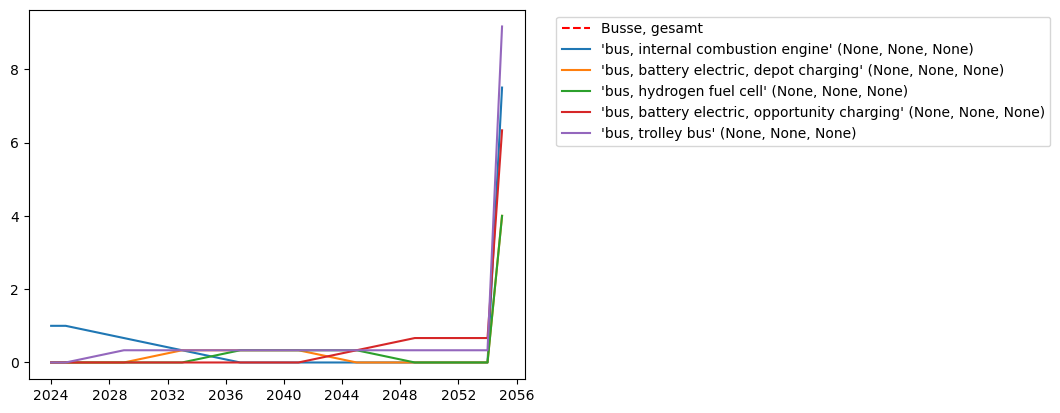

In [40]:
fig, ax = plt.subplots()
ax.plot(anni, valores, 'r--', label = "Busse, gesamt")
c = 0
for cap in capitali.keys():
    ax.plot(anni, capitali[cap], label = cap)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.ylim(bottom=0)
plt.show

In [43]:
anni

[numpy.datetime64('2024'),
 numpy.datetime64('2025'),
 numpy.datetime64('2026'),
 numpy.datetime64('2027'),
 numpy.datetime64('2028'),
 numpy.datetime64('2029'),
 numpy.datetime64('2030'),
 numpy.datetime64('2031'),
 numpy.datetime64('2032'),
 numpy.datetime64('2033'),
 numpy.datetime64('2034'),
 numpy.datetime64('2035'),
 numpy.datetime64('2036'),
 numpy.datetime64('2037'),
 numpy.datetime64('2038'),
 numpy.datetime64('2039'),
 numpy.datetime64('2040'),
 numpy.datetime64('2041'),
 numpy.datetime64('2042'),
 numpy.datetime64('2043'),
 numpy.datetime64('2044'),
 numpy.datetime64('2045'),
 numpy.datetime64('2046'),
 numpy.datetime64('2047'),
 numpy.datetime64('2048'),
 numpy.datetime64('2049'),
 numpy.datetime64('2050'),
 numpy.datetime64('2051'),
 numpy.datetime64('2052'),
 numpy.datetime64('2053'),
 numpy.datetime64('2054'),
 numpy.datetime64('2055')]

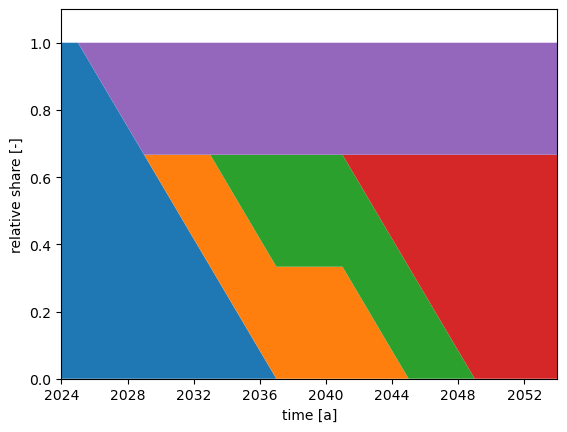

In [46]:
fig, ax = plt.subplots()
ax.plot(anni, valores, 'r--', label = "Busse, gesamt")
c = 0
ax.stackplot(anni, [capitali[cap] for cap in capitali])
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('time [a]')
plt.ylabel('relative share [-]')
plt.xlim(np.datetime64('2024'), np.datetime64('2054'))
plt.ylim(0, 1.1)
plt.show()

# dLCI direct emissions

Solely inventory calculation

In [47]:

try:
    inventario.clear()
except:
    print('first running')

first running


In [48]:
orig = dorig

In [49]:
# analysed databases
iamd = 'i' + dnov

In [50]:
iamd

'ibustransB'

demand on plants like power plants or electrolysers

In [51]:
# Test in the field 'kind' for 'ergosphere' 
erga = [act for act in bd.Database(orig) if 'ergosphere' in act['kind']]
print(erga)


['electricity mix' (None, None, None), 'hydrogen' (None, None, None)]


In [52]:
hads = [0] * len(tempo)

In [53]:
len(hads)

31

In [ ]:
# takes 2 min
inventario, solut = ProspLCI(initio, erga, iamd, fu, hads)

In [55]:
inventario

{'electricity mix' (None, None, None): [0,
  0,
  0.8916667307416609,
  1.7833334614833218,
  2.675000112503767,
  3.5666669229666437,
  4.883333565294745,
  6.200000207622846,
  7.51666673223178,
  8.83333349227905,
  13.460233893472275,
  18.0871342946655,
  22.714034282181604,
  27.34093509705195,
  27.34093509705195,
  27.34093509705195,
  27.34093509705195,
  27.34093509705195,
  27.182601677416066,
  27.024268493218514,
  26.86593508773873,
  26.70760188938508,
  23.239034104236918,
  19.770467560695263,
  16.301900189224217,
  12.833333646257717,
  12.833333646257717,
  12.833333646257717,
  12.833333646257717,
  12.833333646257717,
  12.833333646257717],
 'hydrogen' (None, None, None): [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.08833333919135243,
  0.17666667838270486,
  0.26500000967644155,
  0.3533333567654097,
  0.3533333567654097,
  0.3533333567654097,
  0.3533333567654097,
  0.3533333567654097,
  0.3533333567654097,
  0.3533333567654097,
  0.3533333567654097,
  0

In [56]:
solut

[{'numera': 0, 'anno': 2024, 'db': 'ibustransB0'},
 {'numera': 1, 'anno': 2025, 'db': 'ibustransB1'},
 {'numera': 2, 'anno': 2026, 'db': 'ibustransB2'},
 {'numera': 3, 'anno': 2027, 'db': 'ibustransB3'},
 {'numera': 4, 'anno': 2028, 'db': 'ibustransB4'},
 {'numera': 5, 'anno': 2029, 'db': 'ibustransB5'},
 {'numera': 6, 'anno': 2030, 'db': 'ibustransB6'},
 {'numera': 7, 'anno': 2031, 'db': 'ibustransB7'},
 {'numera': 8, 'anno': 2032, 'db': 'ibustransB8'},
 {'numera': 9, 'anno': 2033, 'db': 'ibustransB9'},
 {'numera': 10, 'anno': 2034, 'db': 'ibustransB10'},
 {'numera': 11, 'anno': 2035, 'db': 'ibustransB11'},
 {'numera': 12, 'anno': 2036, 'db': 'ibustransB12'},
 {'numera': 13, 'anno': 2037, 'db': 'ibustransB13'},
 {'numera': 14, 'anno': 2038, 'db': 'ibustransB14'},
 {'numera': 15, 'anno': 2039, 'db': 'ibustransB15'},
 {'numera': 16, 'anno': 2040, 'db': 'ibustransB16'},
 {'numera': 17, 'anno': 2041, 'db': 'ibustransB17'},
 {'numera': 18, 'anno': 2042, 'db': 'ibustransB18'},
 {'numera': 1

Infrastructure parameters

In [57]:
increase, demand = increDema(inventario, erga)

In [58]:
# Demand for hydrogen
tzHyI = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array(demand['hydrogen']))
suzHyI = tzHyI.total

In [59]:
# Yearly increase in hydrogen demand
tpHyI = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array(increase['hydrogen']))
supHyI = tpHyI.total

In [60]:
# Demand for electricity
tzElI = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array(demand['electricity mix']))
suzElI = tzElI.total

In [61]:
# Yearly increase in electricity demand
tpElI = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array(increase['electricity mix']))
supElI = tpElI.total

In [62]:
tpElI.amount

array([ 0.        ,  0.89166673,  0.89166673,  0.89166665,  0.89166681,
        1.31666664,  1.31666664,  1.31666652,  1.31666676,  4.6269004 ,
        4.6269004 ,  4.62689999,  4.62690081,  0.        ,  0.        ,
        0.        ,  0.        , -0.15833342, -0.15833318, -0.15833341,
       -0.1583332 , -3.46856779, -3.46856654, -3.46856737, -3.46856654,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [63]:
tpHyI.amount

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.08833334,
        0.08833334,  0.08833333,  0.08833335,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.08833335, -0.08833333, -0.08833334, -0.08833334,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

# ecoinvent

In [64]:
ei = bd.Database("ecoinvent_391_6")
len(ei)

21238

In [65]:
ewind = [act for act in ei if act['name']=='wind turbine construction, 2MW, onshore' and 'GLO' in act['location']][0]
ewind

'wind turbine construction, 2MW, onshore' (unit, GLO, None)

In [66]:
ehydro = [act for act in ei if act['name']=='hydropower plant construction, run-of-river' and 'Europe without Switzerland' in act['location']][0]
ehydro


'hydropower plant construction, run-of-river' (unit, Europe without Switzerland, None)

In [67]:
ephoto = [act for act in ei if act['name']=='photovoltaic flat-roof installation, 3kWp, multi-Si, on roof' and 'CH' in act['location']][0]
ephoto

'photovoltaic flat-roof installation, 3kWp, multi-Si, on roof' (unit, CH, None)

In [68]:
aurum = [act for act in ei if act['name']=='market for gold' and 'GLO' in act['location']][0]
aurum

'market for gold' (kilogram, GLO, None)

In [69]:
platin = [act for act in ei if act['name']=='market for platinum' and 'GLO' in act['location']][0]
platin

'market for platinum' (kilogram, GLO, None)

# infrastructure database

In [70]:
database = dinfra

In [71]:
dinfra

'businfraB'

In [72]:
# ----------------------------------------------------------------------------------------------
# Contribution of power plants
fwind = []
for t in tempo:
    fwind.append(1/3) 
fhydr = []
for t in tempo:
    fhydr.append(1/3) 
fphot = []
for t in tempo:
    fphot.append(1/3) 
# ----------------------------------------------------------------------------------------------
# power plants per kWh
pwind = 3539071 # kWh/a
phydr = 15484000000 # kWh/a
pphot = 2766 #kWh/a
tdwind = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array(fwind))
tdhydr = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array(fhydr))
tdphot = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array(fphot))
tnwind = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array([f/pwind for f in fwind]))
tnhydr = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array([f/phydr for f in fhydr]))
tnphot = TemporalDistribution(np.array(tempo, dtype = 'datetime64[Y]'), np.array([f/pphot for f in fphot]))
sunwind = tnwind.total
sunhydr = tnhydr.total
sunphot = tnphot.total
print(tnwind.amount)
print(tnhydr.amount)
print(tnphot.amount)

[9.41866759e-08 9.41866759e-08 9.41866759e-08 9.41866759e-08
 9.41866759e-08 9.41866759e-08 9.41866759e-08 9.41866759e-08
 9.41866759e-08 9.41866759e-08 9.41866759e-08 9.41866759e-08
 9.41866759e-08 9.41866759e-08 9.41866759e-08 9.41866759e-08
 9.41866759e-08 9.41866759e-08 9.41866759e-08 9.41866759e-08
 9.41866759e-08 9.41866759e-08 9.41866759e-08 9.41866759e-08
 9.41866759e-08 9.41866759e-08 9.41866759e-08 9.41866759e-08
 9.41866759e-08 9.41866759e-08 9.41866759e-08]
[2.15275984e-11 2.15275984e-11 2.15275984e-11 2.15275984e-11
 2.15275984e-11 2.15275984e-11 2.15275984e-11 2.15275984e-11
 2.15275984e-11 2.15275984e-11 2.15275984e-11 2.15275984e-11
 2.15275984e-11 2.15275984e-11 2.15275984e-11 2.15275984e-11
 2.15275984e-11 2.15275984e-11 2.15275984e-11 2.15275984e-11
 2.15275984e-11 2.15275984e-11 2.15275984e-11 2.15275984e-11
 2.15275984e-11 2.15275984e-11 2.15275984e-11 2.15275984e-11
 2.15275984e-11 2.15275984e-11 2.15275984e-11]
[0.00012051 0.00012051 0.00012051 0.00012051 0.00012

In [94]:
bd.Database(dinfra).write(
    { 
        (dinfra, 'bus infrastructure'): 
        {
            'code': 'bus infrastructure', 
            'name': 'bus infrastructure', 
            'kind': 'other',
            'exchanges': 
            [
                {
                    'amount': 1.0, 
                    'input': (dinfra, 'bus electricity production'), 
                    'temporal distribution': [(0, 1.0)],
                    'type': 'technosphere'
                }
                ,
                {
                    'amount': 1.0, 
                    'input': (dinfra, 'bus hydrogen'), 
                    'temporal distribution': [(0, 1.0)],
                    'type': 'technosphere'
                }
            ]
        }
        ,
        (dinfra, 'bus electricity production'): 
        {
            'code': 'bus electricity production', 
            'name': 'bus electricity production', 
            'kind': 'other',
            'exchanges': 
            [
                {
                    'amount': supElI, # additionally build power plants [kWh/a]
                    'input': (dinfra, 'bus electricity mix'), 
                    'temporal distribution': tpElI,
                    'type': 'technosphere'
                }
            ]
        }
        , 
        (dinfra, 'bus electricity mix'): 
        {
            'code': 'bus electricity mix', 
            'name': 'bus electricity mix', 
            'kind': 'other',
            'exchanges':
            [
                {
                    'amount': sunwind, 
                    'input': (ewind), 
                    'temporal distribution': tnwind,
                    'type': 'technosphere'
                }
                ,
                {
                    'amount': sunhydr, 
                    'input': (ehydro), 
                    'temporal distribution': tnhydr,
                    'type': 'technosphere'
                }
                ,
                {
                    'amount': sunphot, 
                    'input': (ephoto), 
                    'temporal distribution': tnphot,
                    'type': 'technosphere'
                }            
            ]
        }
        , 
        (dinfra, 'bus hydrogen'): 
        {
            'code': 'bus hydrogen', 
            'name': 'bus hydrogen', 
            'kind': 'other',
            'exchanges':
            [
                {
                    'amount': supHyI, 
                    'input': (dinfra, 'bus electrolyser'), 
                    'temporal distribution': tpHyI,
                    'type': 'technosphere'
                }              
            ]
        }
        , 
        (dinfra, 'bus electrolyser'): 
        {
            'code': 'bus electrolyser', 
            'name': 'bus electrolyser', 
            'kind': 'other',
            'exchanges':
            [
                {
                    'amount': 0.0000591, # kg/kg/a
                    'input': (platin), 
                    'temporal distribution': [(0, 0.0000591)],
                    'type': 'technosphere'
                }   
                ,
                {
                    'amount': 0.000000137, # kg/kg/a
                    'input': (aurum), 
                    'temporal distribution': [(0, 0.000000137)],
                    'type': 'technosphere'
                }            
            ]
        }
    }
)

Writing activities to SQLite3 database:
0% [#####] 100% | ETA: 00:00:01
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 06/13/2025 10:17:21
  Finished: 06/13/2025 10:17:21
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 3.00


copy infrastructure

In [84]:
fu = fuIS

In [ ]:
# WITH PROSPECTIVE BACKGROUND
# ---------------------------
# Activate the recursion, which copies the dynamic foreground inventory for each year to a separate database
# When prospective background data is applied, the parameters einv and preinv are set to the names of the original and the modified databases, respectively
# (The name of the modified databases without year)


num = 0
inv = []
ts = {}
oridat = dinfra
novidat = dinov

for a in tdfu.date:
    datbk = Copy_Recurs(oridat, novidat, bdat, preinv, fu, str(a.astype(object).year), num, ts)
    inv.append([num, a, ts.copy()])
    print(ts)
    bd.Database(datbk).write(ts.copy())
    num = num + 1
    ts.clear()
    
print(inv) 

# Save bus transport inventory as excel

Plot dyn. inventory

In [73]:
tide = []
for an in solut:
    tide.append(an['anno'])

In [74]:
inventario.keys()

dict_keys(['electricity mix' (None, None, None), 'hydrogen' (None, None, None), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground')), 'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground')), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'low population density, long-term')), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')), 'Carbon dioxide, fossil' (kilogram, None, ('air',)), 'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Methane, fossil' (kilogram, None, ('air', 'low population density, long-term')), 'Methane, fossil' (kilogram, None, ('air',)), 'Dinitrogen monoxide' (kilogram, None, ('air', 'urban air close to ground')), 'Dinitrogen monoxide' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Dinitrogen monoxide' (kilogram, None, ('air', 'low population den

In [75]:
dfin = pd.DataFrame(inventario, index=tide)
dfin

,"[code, name, kind, database]","[code, name, kind, database]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]"
2024,0.000000,0.000000,1.537924e-01,7.079227e-05,9.107438e-01,1.579920e-07,2.303089e-08,1.165088e+01,4.065681e-02,0.0,8.162147e-05,3.033258e-05,1.685887e-05,2.790006e-09,6.843101e-04
2025,0.000000,0.000000,1.632150e-01,7.432628e-05,8.982539e-01,1.596512e-07,2.325425e-08,1.165091e+01,4.051011e-02,0.0,8.142902e-05,3.260782e-05,1.714673e-05,2.819110e-09,7.449977e-04
2026,0.891667,0.000000,1.581786e-01,7.135005e-05,8.176050e-01,1.508849e-07,2.151498e-08,1.067989e+01,3.699372e-02,0.0,7.444980e-05,3.192962e-05,1.610423e-05,2.662328e-09,7.374390e-04
2027,1.783333,0.000000,1.515730e-01,6.779279e-05,7.376785e-01,1.412947e-07,1.974020e-08,9.708867e+00,3.350187e-02,0.0,6.750545e-05,3.088062e-05,1.498574e-05,2.491301e-09,7.200071e-04
2028,2.675000,0.000000,1.434016e-01,6.365326e-05,6.585734e-01,1.308802e-07,1.792973e-08,8.737857e+00,3.003487e-02,0.0,6.059605e-05,2.946085e-05,1.379297e-05,2.306039e-09,6.926900e-04
2029,3.566667,0.000000,1.336683e-01,5.893024e-05,5.803891e-01,1.196410e-07,1.608338e-08,7.766859e+00,2.659302e-02,0.0,5.372171e-05,2.767030e-05,1.252766e-05,2.106554e-09,6.554755e-04
2030,4.883334,0.000000,1.223764e-01,5.362255e-05,5.032248e-01,1.075769e-07,1.420097e-08,6.795879e+00,2.317663e-02,0.0,4.688250e-05,2.550900e-05,1.119151e-05,1.892854e-09,6.083513e-04
2031,6.200000,0.000000,1.091489e-01,4.756178e-05,4.291710e-01,9.977169e-08,1.225797e-08,5.824674e+00,1.977607e-02,0.0,4.005339e-05,2.283444e-05,9.797768e-06,1.753983e-09,5.470631e-04
2032,7.516667,0.000000,9.449912e-02,4.097003e-05,3.557291e-01,8.944877e-08,1.028650e-08,4.853580e+00,1.640493e-02,0.0,3.326800e-05,1.983654e-05,8.334066e-06,1.571301e-09,4.772517e-04
2033,8.833333,0.000000,7.842945e-02,3.384597e-05,2.829653e-01,7.660618e-08,8.286499e-09,3.882605e+00,1.306347e-02,0.0,2.652644e-05,1.651539e-05,6.801375e-06,1.344788e-09,3.989071e-04


In [100]:
dfin.to_excel("THG_" + dorig + "_roh.xlsx")

Summed up for impact assessment

In [76]:
SumEmis(inventario)

,year,process,CO2,CH4,N2O
0,2024,Sum,1.271541e+01,4.080922e-02,7.315043e-04
1,2025,Sum,1.271237e+01,4.066586e-02,7.947551e-04
2,2026,Sum,1.165567e+01,3.713952e-02,7.854756e-04
3,2027,Sum,1.059812e+01,3.363717e-02,7.658760e-04
4,2028,Sum,9.539832e+00,3.015912e-02,7.359461e-04
5,2029,Sum,8.480916e+00,2.670567e-02,6.956755e-04
6,2030,Sum,7.421480e+00,2.327713e-02,6.450537e-04
7,2031,Sum,6.362994e+00,1.986369e-02,5.796971e-04
8,2032,Sum,5.303808e+00,1.647917e-02,5.054239e-04
9,2033,Sum,4.243999e+00,1.312384e-02,4.222253e-04


In [102]:
SumEmis(inventario).to_excel("THG_" + dorig + "sum.xlsx")

# dLCI infrastructure

In [77]:
try:
    inventario.clear()
except:
    print('first running')

In [78]:
dinfra

'businfraB'

In [79]:
iamd = 'i' + dinfra
ecod = 'e' + dinfra

demand on plants like power plants or electrolysers

In [80]:
# Test in the field 'kind' for 'ergosphere' 
erga = [act for act in bd.Database(dinfra) if 'ergosphere' in act['kind']]
print(erga)


[]


In [81]:
hads = [0] * len(tempo)

In [82]:
len(hads)

31

In [ ]:
# takes 2 min
isinventario, issolut = ProspLCI(initio, erga, iamd, fu, hads)

In [86]:
tide = []
for an in issolut:
    tide.append(an['anno'])

In [87]:
isinventario.keys()

dict_keys(['Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground')), 'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground')), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'low population density, long-term')), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')), 'Carbon dioxide, fossil' (kilogram, None, ('air',)), 'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Methane, fossil' (kilogram, None, ('air', 'low population density, long-term')), 'Methane, fossil' (kilogram, None, ('air',)), 'Dinitrogen monoxide' (kilogram, None, ('air', 'urban air close to ground')), 'Dinitrogen monoxide' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Dinitrogen monoxide' (kilogram, None, ('air', 'low population density, long-term')), 'Dinitrogen monoxide' (kilogram, None, ('air',))]

In [88]:
isinventario.values()

dict_values([[0, 0.10538861560367352, 0.10399848755016806, 0.10264003678165558, 0.10131194942676876, 0.14768259460348052, 0.1458055808846457, 0.14444756738484313, 0.1431199085629392, 0.5226476260250821, 0.5180707873182654, 0.5135879304469274, 0.510749673843256, 0, 0, 0, 0, -0.016218589962352252, -0.016151429158544724, -0.016085789819364604, -0.016021531220171175, -0.3736978604628026, -0.3724421966436737, -0.37121451180564, -0.37001352715254654, 0, 0, 0, 0, 0, 0], [0, 0.00024342729694629123, 0.0002421248118920925, 0.0002408567228120014, 0.0002396217382912832, 0.0003520571251157905, 0.00035032553585307585, 0.0003486333315380799, 0.00034698410165797, 0.0012431572659279072, 0.001237719890130265, 0.0012324169218763633, 0.0012271154096152848, 0, 0, 0, 0, -4.011838269089915e-05, -3.995460817053055e-05, -3.9794684171907535e-05, -3.9638261727702156e-05, -0.0008950933184907004, -0.0008918304659089978, -0.0008886403111932135, -0.0008855196536120076, 0, 0, 0, 0, 0, 0], [0, 0.26592790501388863, 0.2

In [89]:
dfin = pd.DataFrame(isinventario, index=tide)
dfin

,"[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]"
2024,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2025,0.105389,0.000243,0.265928,3.589666e-08,4.965514e-07,0.156456,0.001784,0.0,0.000012,0.000007,4.854279e-06,7.117808e-10,2.755119e-06
2026,0.103998,0.000242,0.249022,3.550121e-08,4.965300e-07,0.155783,0.001709,0.0,0.000012,0.000007,4.564737e-06,6.999927e-10,2.781071e-06
2027,0.102640,0.000241,0.232552,3.511633e-08,4.965092e-07,0.155127,0.001636,0.0,0.000012,0.000007,4.282659e-06,6.884607e-10,2.805877e-06
2028,0.101312,0.000240,0.216501,3.474160e-08,4.964891e-07,0.154489,0.001565,0.0,0.000012,0.000006,4.007736e-06,6.771735e-10,2.829553e-06
2029,0.147683,0.000352,0.296585,5.076168e-08,7.331044e-07,0.227206,0.002209,0.0,0.000018,0.000009,5.522137e-06,9.836161e-10,4.211531e-06
2030,0.145806,0.000350,0.274044,5.023649e-08,7.330763e-07,0.226312,0.002110,0.0,0.000017,0.000009,5.136039e-06,9.676242e-10,4.243221e-06
2031,0.144448,0.000349,0.257923,4.977468e-08,7.330371e-07,0.225472,0.002032,0.0,0.000017,0.000009,4.855284e-06,9.548506e-10,4.277875e-06
2032,0.143120,0.000347,0.242188,4.932404e-08,7.329992e-07,0.224653,0.001955,0.0,0.000017,0.000009,4.581306e-06,9.423271e-10,4.311188e-06
2033,0.522648,0.001243,0.854853,1.764577e-07,2.580330e-06,0.815561,0.006968,0.0,0.000062,0.000074,1.614084e-05,3.352601e-09,1.698233e-05


save as excel

In [114]:
dfin.to_excel("THG_Infra_" + dorig + "_roh.xlsx")

In [90]:
SumEmis(isinventario)

,year,process,CO2,CH4,N2O
0,2024,Sum,0.000000,0.000000,0.000000
1,2025,Sum,0.527773,0.002040,0.000014
2,2026,Sum,0.508803,0.001963,0.000014
3,2027,Sum,0.490320,0.001889,0.000014
4,2028,Sum,0.472303,0.001816,0.000013
5,2029,Sum,0.671474,0.002579,0.000019
6,2030,Sum,0.646162,0.002478,0.000019
7,2031,Sum,0.627843,0.002397,0.000018
8,2032,Sum,0.609962,0.002319,0.000018
9,2033,Sum,2.193065,0.008274,0.000107


In [116]:
SumEmis(isinventario).to_excel("THG_Infra_" + dorig + "sum.xlsx")

# Bus fleet production

In [91]:
fu = fufl

In [ ]:
# WITH STATIC BACKGROUND
# ---------------------------
# Activate the recursion, which copies the dynamic foreground inventory for each year to a separate database
# When static background data is applied, the parameters einv and preinv are set to 0 

num = 0
inv = []
ts = {}
oridat = dfleet
novidat = dflnov

for a in tdfu.date:
    datbk = Copy_Recurs(oridat, novidat, 0, 0, fu, str(a.astype(object).year), num, ts)
    inv.append([num, a, ts.copy()])
    print(ts)
    bd.Database(datbk).write(ts.copy())
    num = num + 1
    ts.clear()
    
print(inv) 

Including IAMs

In [ ]:
# WITH PROSPECTIVE BACKGROUND
# ---------------------------
# Activate the recursion, which copies the dynamic foreground inventory for each year to a separate database
# When prospective background data is applied, the parameters einv and preinv are set to the names of the original and the modified databases, respectively
# (The name of the modified databases without year)


num = 0
inv = []
ts = {}
oridat = dfleet
novidat = dflnov

for a in tdfu.date:
    datbk = Copy_Recurs(oridat, novidat, bdat, preinv, fu, str(a.astype(object).year), num, ts)
    inv.append([num, a, ts.copy()])
    print(ts)
    bd.Database(datbk).write(ts.copy())
    num = num + 1
    ts.clear()
    
print(inv) 

# dLCI bus fleet production

In [92]:

try:
    inventario.clear()
except:
    print('first running')

In [93]:
orig = dfleet

In [94]:
# analysed databases
iamd = 'i' + dflnov

In [95]:
iamd

'ibusprodB'

In [96]:
# Test in the field 'kind' for 'ergosphere' 
erga = [act for act in bd.Database(orig) if 'ergosphere' in act['kind']]
print(erga)


[]


In [97]:
hads = [0] * len(tempo)

In [98]:
len(hads)

31

In [ ]:
# takes 2 min
flinventario, flsolut = ProspLCI(initio, erga, iamd, fu, hads)

In [100]:
tide = []
for an in flsolut:
    tide.append(an['anno'])

In [101]:
flinventario.keys()

dict_keys(['Carbon dioxide, fossil' (kilogram, None, ('air', 'urban air close to ground')), 'Methane, fossil' (kilogram, None, ('air', 'urban air close to ground')), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'low population density, long-term')), 'Carbon dioxide, fossil' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')), 'Carbon dioxide, fossil' (kilogram, None, ('air',)), 'Methane, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Methane, fossil' (kilogram, None, ('air', 'low population density, long-term')), 'Methane, fossil' (kilogram, None, ('air',)), 'Dinitrogen monoxide' (kilogram, None, ('air', 'urban air close to ground')), 'Dinitrogen monoxide' (kilogram, None, ('air', 'non-urban air or from high stacks')), 'Dinitrogen monoxide' (kilogram, None, ('air', 'low population density, long-term')), 'Dinitrogen monoxide' (kilogram, None, ('air',))]

In [102]:
flinventario.values()

dict_values([[0.09848396577971091, 0.09810933068777634, 0.1020885462115872, 0.10173326486330128, 0.10137827855061424, 0.1010235857977648, 0.1451259891735687, 0.1446904008389164, 0.1442550640452083, 0.1438199751890258, 0.5235754852468161, 0.5225202367991514, 0.5223252727654956, 0.5221337827851954, 0.09967603619053683, 0.0996473305101061, 0.09961860172939267, 0.09962136725256997, 0.11545324523313406, 0.11545365660561215, 0.11545405379350664, 0.11545443341865744, 0.11548499944642808, 0.11551555433158366, 0.11554609438201206, 0.11557661655537334, 0.09977389788609325, 0.09977389788609325, 0.09977389788609325, 0.09977389788609325, 0.11560711783324835], [0.00014522443366042764, 0.0001452687483626734, 0.00015773030349866494, 0.00015777925074415646, 0.00015782729653797712, 0.0001578744805198687, 0.00029268471442678426, 0.00029277658026798337, 0.00029286740522463075, 0.0002929572323715405, 0.0011709464576936525, 0.0011711317367127032, 0.0011712869357145526, 0.0011714415484651796, 0.0001582365800

In [103]:
dfin = pd.DataFrame(flinventario, index=tide)
dfin

,"[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]","[categories, code, CAS number, name, database, unit, type]"
2024,0.098484,0.000145,0.185923,3.887261e-08,3.976035e-09,0.155925,0.001636,0.0,0.000011,0.000003,0.000003,7.047018e-10,0.000003
2025,0.098109,0.000145,0.176773,3.883891e-08,3.983558e-09,0.155779,0.001604,0.0,0.000011,0.000003,0.000003,7.038762e-10,0.000003
2026,0.102089,0.000158,0.184869,3.974286e-08,1.027301e-08,0.159451,0.001666,0.0,0.000012,0.000004,0.000003,7.224672e-10,0.000003
2027,0.101733,0.000158,0.178373,3.970725e-08,1.028238e-08,0.159317,0.001640,0.0,0.000012,0.000004,0.000003,7.203515e-10,0.000003
2028,0.101378,0.000158,0.171916,3.967179e-08,1.029169e-08,0.159184,0.001616,0.0,0.000012,0.000004,0.000003,7.182266e-10,0.000003
2029,0.101024,0.000158,0.165498,3.963651e-08,1.030093e-08,0.159051,0.001591,0.0,0.000012,0.000004,0.000003,7.160926e-10,0.000003
2030,0.145126,0.000293,0.276949,4.950145e-08,7.844239e-08,0.199706,0.002343,0.0,0.000014,0.000006,0.000005,9.219487e-10,0.000004
2031,0.144690,0.000293,0.266648,4.945515e-08,7.845420e-08,0.199505,0.002299,0.0,0.000014,0.000006,0.000005,9.185990e-10,0.000004
2032,0.144255,0.000293,0.256414,4.940858e-08,7.846592e-08,0.199306,0.002256,0.0,0.000014,0.000006,0.000004,9.152178e-10,0.000005
2033,0.143820,0.000293,0.246248,4.936174e-08,7.847755e-08,0.199108,0.002212,0.0,0.000014,0.000006,0.000004,9.118050e-10,0.000005


save as excel

In [131]:
dfin.to_excel("THG_Fleet_" + dorig + "_roh.xlsx")

In [104]:
SumEmis(flinventario)

,year,process,CO2,CH4,N2O
0,2024,Sum,0.440332,0.001792,0.000010
1,2025,Sum,0.430661,0.001761,0.000010
2,2026,Sum,0.446408,0.001835,0.000010
3,2027,Sum,0.439423,0.001810,0.000010
4,2028,Sum,0.432478,0.001785,0.000010
5,2029,Sum,0.425573,0.001760,0.000010
6,2030,Sum,0.621781,0.002649,0.000015
7,2031,Sum,0.610843,0.002605,0.000015
8,2032,Sum,0.599975,0.002562,0.000015
9,2033,Sum,0.589176,0.002519,0.000015


In [133]:
SumEmis(flinventario).to_excel("THG_fleet_" + dorig + "sum.xlsx")

# Static impact assessment

IPCC 2021

bus transport

In [105]:
iamd = 'i' + dnov

In [106]:
fu = fuorig

In [ ]:
solut, processi = ProspIA(initio, ipcc, iamd, fu, 3)
solut

In [108]:
print(processi)

['bus, internal combustion engine', 'natural gas venting from petroleum/natural gas production', 'diesel production, petroleum refinery operation', 'farming and supply of rapeseed']


In [109]:
capitali = ProspCapit(solut, processi, ipcc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
{'bus, internal combustion engine': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'natural gas venting from petroleum/natural gas production': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'diesel production, petroleum refinery operation': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'farming and supply of rapeseed': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
      n  time         value
0   Na

In [110]:
anni = [an.get('anno') for an in solut]
anni

[2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 2050,
 2051,
 2052,
 2053,
 2054]

In [111]:
valores = [an.get(ipcc) for an in solut]
valores

[14.136493345724384,
 14.146562332935918,
 12.98187392998089,
 11.814221260525798,
 10.643720594636338,
 9.470486288378092,
 8.29463224886852,
 7.116151777666781,
 5.935381653370633,
 4.752403271017996,
 3.5672960139212213,
 2.38014028918529,
 1.190201733998347,
 -4.129743124240164e-15,
 -4.1300892380371304e-15,
 -4.1303802565805466e-15,
 -4.130616341867234e-15,
 -4.1282790154485316e-15,
 -4.125895929289457e-15,
 -4.123467241299634e-15,
 -4.1209930812917836e-15,
 -4.118473730970815e-15,
 -4.116245484354153e-15,
 -4.113875056775541e-15,
 -4.111362591259335e-15,
 -4.1087083931479044e-15,
 -4.105912632669765e-15,
 -4.105912632669765e-15,
 -4.105912632669765e-15,
 -4.105912632669765e-15,
 -4.105912632669765e-15]

In [112]:
trans = valores

<function matplotlib.pyplot.show(close=None, block=None)>

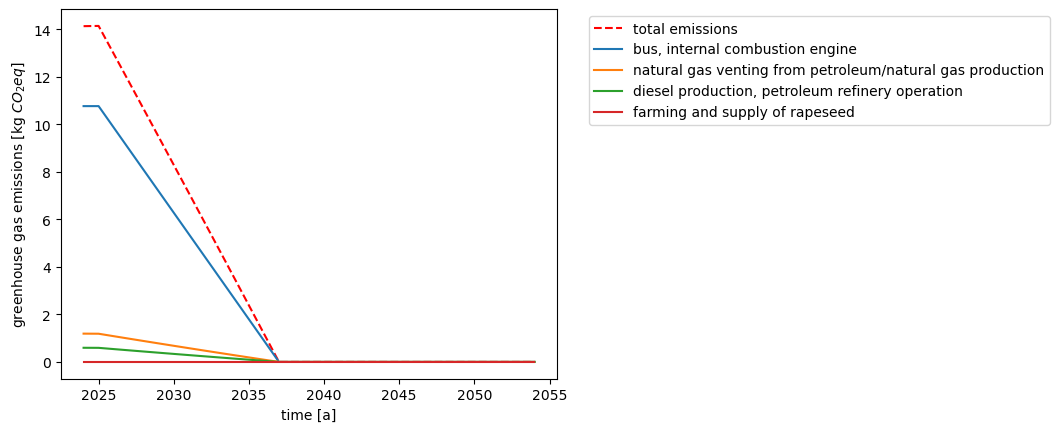

In [113]:

fig, ax = plt.subplots()
ax.plot(anni, valores, 'r--', label = "total emissions")
c = 0
for cap in capitali.keys():
    ax.plot(anni, capitali[cap], label = cap)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.ylim(bottom=0)
plt.xlabel('time [a]')
plt.ylabel('greenhouse gas emissions [kg $CO_2 eq$]')
plt.show

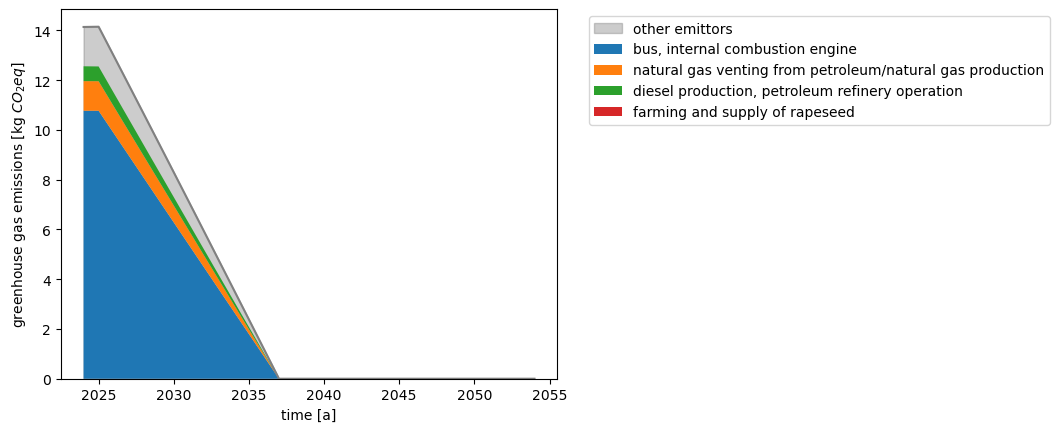

In [114]:
fig, ax = plt.subplots()
ax.plot(anni, valores, 'grey')
ax.fill_between(anni, valores, 0, color='grey', alpha=.4, label = 'other emittors')
c = 0
ax.stackplot(anni, [capitali[cap] for cap in capitali], labels = [pro for pro in processi])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.xlim(2024, 2056)
#plt.ylim(0, 1.2e10)
plt.xlabel('time [a]')
plt.ylabel('greenhouse gas emissions [kg $CO_2 eq$]')
plt.show()

bus fleet

In [117]:
iamd = 'i' + dflnov

In [118]:
fu = fufl

In [ ]:
flsolut, flprocessi = ProspIA(initio, ipcc, iamd, fu, 9)
flsolut

In [120]:
print(flprocessi)

['pig iron production', 'heat production, at hard coal industrial furnace 1-10MW', 'hard coal mine operation and hard coal preparation', 'heat production, natural gas, at industrial furnace >100kW', 'iron sinter production', 'natural gas venting from petroleum/natural gas production', 'ethylene production, average', 'bus production', 'quicklime production, in pieces, loose', 'aluminium production, primary, liquid, prebake', 'acrylonitrile-butadiene-styrene copolymer production', 'carbon fibre reinforced plastic, injection moulded', 'heat production, heavy fuel oil, at industrial furnace 1MW']


In [121]:
capitali = ProspCapit(flsolut, flprocessi, ipcc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
{'pig iron production': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'heat production, at hard coal industrial furnace 1-10MW': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'hard coal mine operation and hard coal preparation': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'heat production, natural gas, at industrial furnace >100kW': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'iron sinter prod

In [122]:
anni = [an.get('anno') for an in flsolut]
anni

[2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 2050,
 2051,
 2052,
 2053,
 2054]

In [123]:
valores = [an.get(ipcc) for an in flsolut]
valores

[0.504742328440231,
 0.4941120446324939,
 0.512741855455597,
 0.5049771835427901,
 0.4972601722195549,
 0.48959007167334867,
 0.7196093058470937,
 0.7072937522274775,
 0.6950586636662259,
 0.6829031418345327,
 1.133197001251986,
 1.105732065709795,
 1.0897689424101586,
 1.0738208438710928,
 0.4488528278672109,
 0.4462323094732469,
 0.44361593710583586,
 0.44252131064273753,
 0.5078273056771321,
 0.5063166913475161,
 0.5048124518886199,
 0.5033143990862241,
 0.5026332743698013,
 0.5019557662792283,
 0.5012818107295381,
 0.5006113757979703,
 0.4354326825019738,
 0.4354326825019738,
 0.4354326825019738,
 0.4354326825019738,
 0.4999444040100671]

In [124]:
prod = valores

<function matplotlib.pyplot.show(close=None, block=None)>

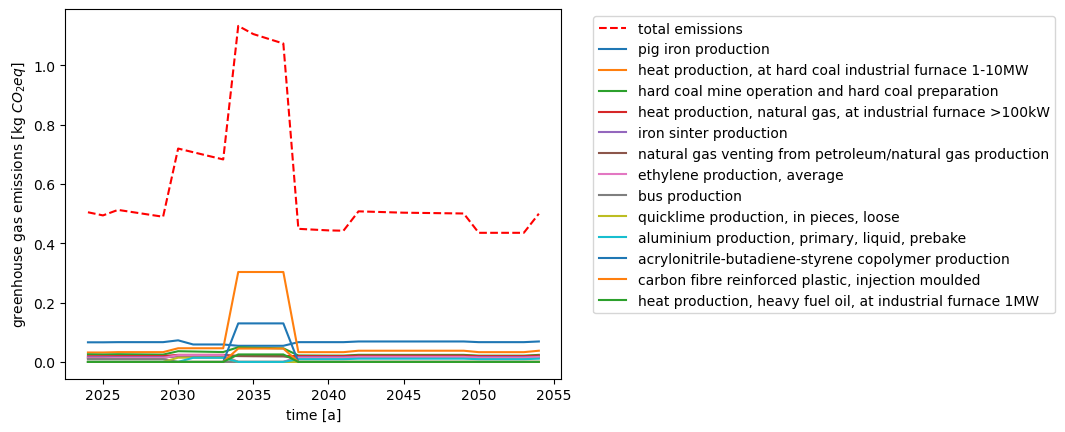

In [125]:

fig, ax = plt.subplots()
ax.plot(anni, valores, 'r--', label = "total emissions")
c = 0
for cap in capitali.keys():
    ax.plot(anni, capitali[cap], label = cap)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.ylim(bottom=0)
plt.xlabel('time [a]')
plt.ylabel('greenhouse gas emissions [kg $CO_2 eq$]')
plt.show

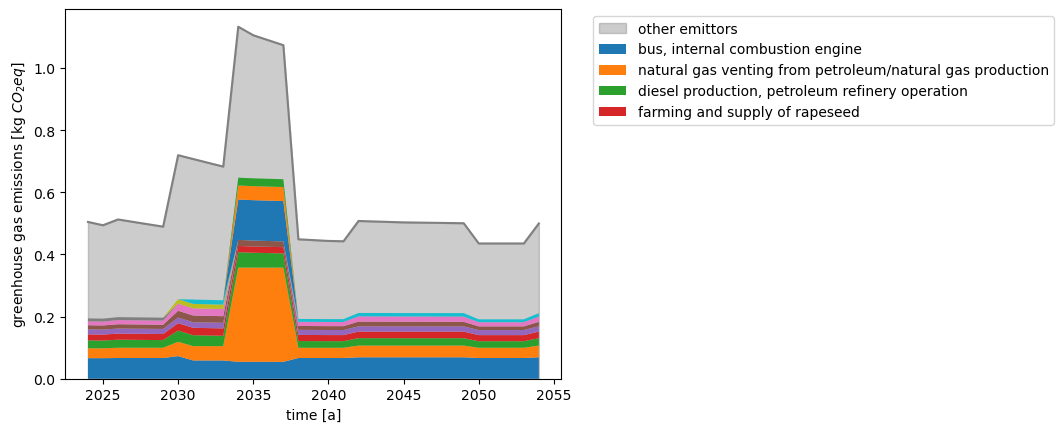

In [126]:
fig, ax = plt.subplots()
ax.plot(anni, valores, 'grey')
ax.fill_between(anni, valores, 0, color='grey', alpha=.4, label = 'other emittors')
c = 0
ax.stackplot(anni, [capitali[cap] for cap in capitali], labels = [pro for pro in processi])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.xlim(2024, 2056)
#plt.ylim(0, 1.2e10)
plt.xlabel('time [a]')
plt.ylabel('greenhouse gas emissions [kg $CO_2 eq$]')
plt.show()

infrastructure

In [127]:
iamd = 'i' + dinov

In [128]:
fu = fuIS

In [ ]:
issolut, isprocessi = ProspIA(initio, ipcc, iamd, fu, 9)
issolut

In [130]:
print(isprocessi)

['clinker production', 'hard coal mine operation and hard coal preparation', 'heat production, at hard coal industrial furnace 1-10MW', 'pig iron production', 'diesel, burned in building machine', 'natural gas venting from petroleum/natural gas production', 'ethylene production, average', 'heat and power co-generation, hard coal', 'electricity production, hard coal', 'flat glass production, uncoated', 'electricity production, hard coal, conventional', 'nylon 6-6 production, glass-filled']


In [131]:
capitali = ProspCapit(issolut, isprocessi, ipcc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
{'clinker production': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'hard coal mine operation and hard coal preparation': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'heat production, at hard coal industrial furnace 1-10MW': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'pig iron production': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'diesel, burned in building machine': [0.0, 0.0, 0.0, 0.0

In [132]:
anni = [an.get('anno') for an in issolut]
anni

[2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 2050,
 2051,
 2052,
 2053,
 2054]

In [133]:
valores = [an.get(ipcc) for an in issolut]
valores

[0.0,
 0.6083480196867773,
 0.5868053122024198,
 0.5658227022368386,
 0.5453769386732953,
 0.7758916662546881,
 0.7471898266679592,
 0.7261410009148813,
 0.7056018612342023,
 2.547770651149675,
 2.472286983608382,
 2.3984299200270174,
 2.3530736508636485,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.07050495196507392,
 -0.07000700641251181,
 -0.06951799840906299,
 -0.06903724539366105,
 -1.5956140238768022,
 -1.5880546390278274,
 -1.5806378459413948,
 -1.5733575184016706,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [134]:
powe = []
n = 0
for t in tempo:
    if valores[n] > 0.0:
        powe.append(valores[n])
    else:
        powe.append(0.0)
    n += 1
#valores.clear()

<function matplotlib.pyplot.show(close=None, block=None)>

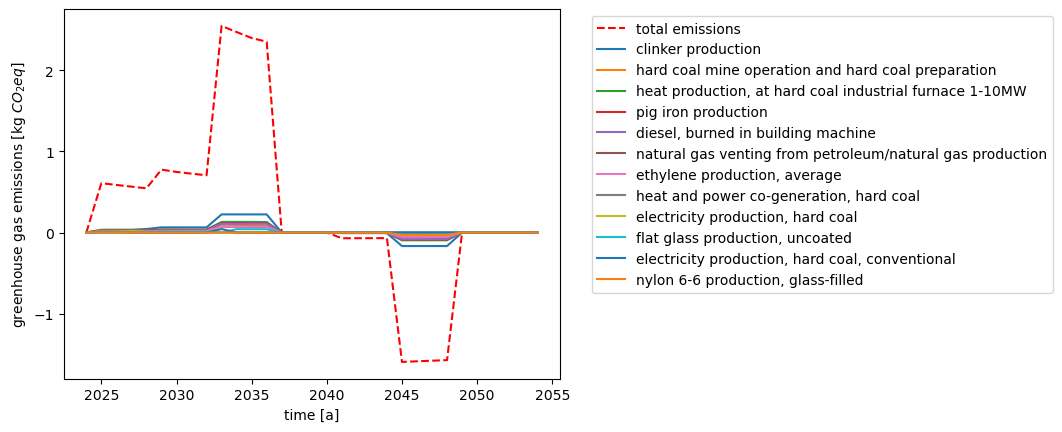

In [135]:

fig, ax = plt.subplots()
ax.plot(anni, valores, 'r--', label = "total emissions")
c = 0
for cap in capitali.keys():
    ax.plot(anni, capitali[cap], label = cap)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.ylim(bottom=0)
plt.xlabel('time [a]')
plt.ylabel('greenhouse gas emissions [kg $CO_2 eq$]')
plt.show

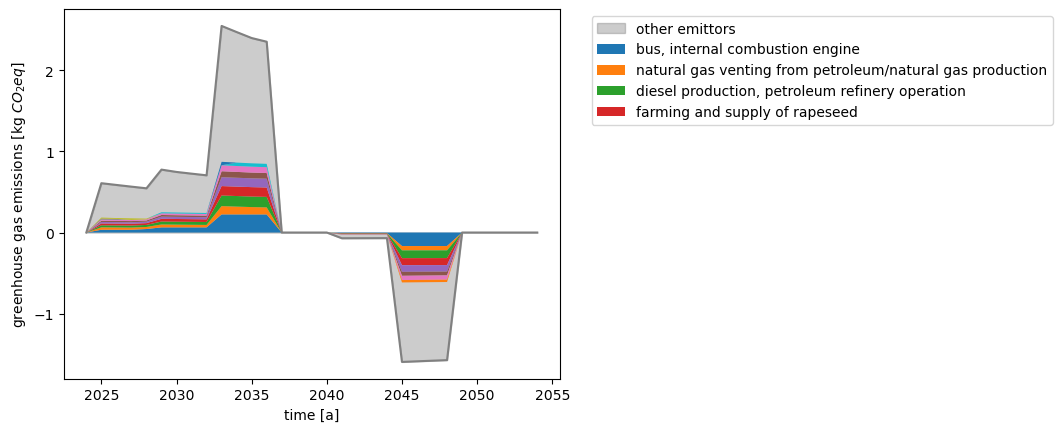

In [136]:
fig, ax = plt.subplots()
ax.plot(anni, valores, 'grey')
ax.fill_between(anni, valores, 0, color='grey', alpha=.4, label = 'other emittors')
c = 0
ax.stackplot(anni, [capitali[cap] for cap in capitali], labels = [pro for pro in processi])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.xlim(2024, 2056)
#plt.ylim(0, 1.2e10)
plt.xlabel('time [a]')
plt.ylabel('greenhouse gas emissions [kg $CO_2 eq$]')
plt.show()

# Plots

In [137]:
powe

[0.0,
 0.6083480196867773,
 0.5868053122024198,
 0.5658227022368386,
 0.5453769386732953,
 0.7758916662546881,
 0.7471898266679592,
 0.7261410009148813,
 0.7056018612342023,
 2.547770651149675,
 2.472286983608382,
 2.3984299200270174,
 2.3530736508636485,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

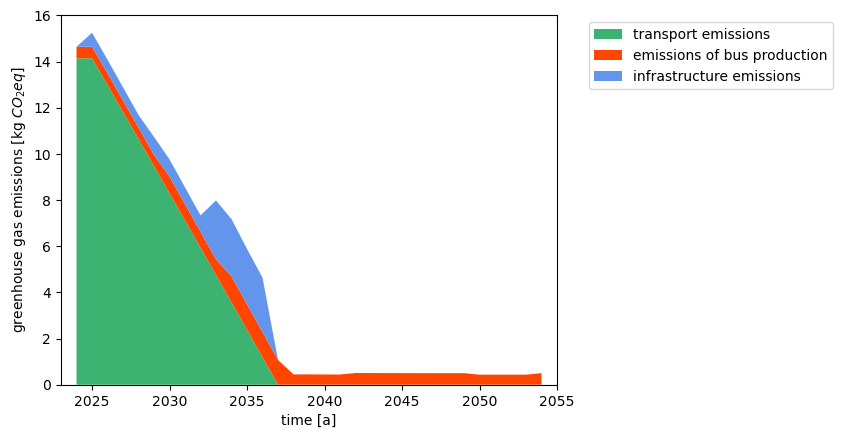

In [138]:
fig, ax = plt.subplots()
dct_color = {'transport emissions': 'mediumseagreen', 'emissions of bus production': 'orangered', 'infrastructure emissions': 'cornflowerblue', 'd': 'yellow'}
c = 0
ax.stackplot(anni, trans, prod, powe, labels=['transport emissions', 'emissions of bus production', 'infrastructure emissions'], colors=[dct_color.get(l) for l in ['transport emissions', 'emissions of bus production', 'infrastructure emissions']])
#plt.xlim(np.datetime64('2024-01-01', 'Y'), np.datetime64('2056-01-01', 'Y'))
plt.xlim(2023, 2055)
#plt.title('1 t steel production, scenario 4')
#plt.ylim(0, 2000)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('time [a]')
plt.ylabel('greenhouse gas emissions [kg $CO_2 eq$]')
plt.show()

In [140]:
alle = pd.read_excel('Radforc_THG_bustransBsum_alle.xlsx', skiprows=(0,2))

In [141]:
alle

,Unnamed: 0,CO2,CH4,N2O
0,2023,0.000000e+00,0.000000e+00,0.000000e+00
1,2024,2.312416e-14,9.002810e-15,2.728617e-16
2,2025,4.563962e-14,1.770218e-14,5.719885e-16
3,2026,6.499811e-14,2.498174e-14,8.652961e-16
4,2027,8.151432e-14,3.093615e-14,1.148836e-15
...,...,...,...,...
73,2096,1.191360e-13,5.295194e-15,1.913032e-15
74,2097,1.191418e-13,5.269418e-15,1.901679e-15
75,2098,1.191532e-13,5.245639e-15,1.890420e-15
76,2099,1.191699e-13,5.223702e-15,1.879254e-15


In [142]:
alle.rename( columns={'Unnamed: 0':'tempo'}, inplace=True )


In [143]:
radiat = {('Sum', 'CO2'): list(alle['CO2']),('Sum', 'CH4'):  list(alle['CH4']),('Sum', 'N2O'):  list(alle['N2O'])}

In [144]:
radiat

{('Sum', 'CO2'): [0.0,
  2.312416407064047e-14,
  4.563961762529724e-14,
  6.499810670452129e-14,
  8.151432272623258e-14,
  9.547579558732832e-14,
  1.074951328543988e-13,
  1.17696266647721e-13,
  1.258631826905032e-13,
  1.321276495022357e-13,
  1.394108209212176e-13,
  1.454480331529364e-13,
  1.495509984892803e-13,
  1.518855970458673e-13,
  1.490467153396043e-13,
  1.458068523634348e-13,
  1.430806862379048e-13,
  1.407663289487141e-13,
  1.387852010436448e-13,
  1.371714664102063e-13,
  1.357682490533721e-13,
  1.345360896848638e-13,
  1.33443592015822e-13,
  1.324670139461718e-13,
  1.315863399442831e-13,
  1.307855934237811e-13,
  1.300520024142825e-13,
  1.292797073658466e-13,
  1.285634473817761e-13,
  1.278953847050889e-13,
  1.272692040909822e-13,
  1.267754305926176e-13,
  1.263080280417591e-13,
  1.258647727157188e-13,
  1.254438136786919e-13,
  1.250435978777483e-13,
  1.246628107039356e-13,
  1.243003288139265e-13,
  1.239551826719821e-13,
  1.236265267986134e-13,
  1.

In [145]:
anniRF = [anni[0]-1]
for a in anni:
    anniRF.append(a)
del(anniRF[-1])
anniRF

[2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 2050,
 2051,
 2052,
 2053]

<function matplotlib.pyplot.show(close=None, block=None)>

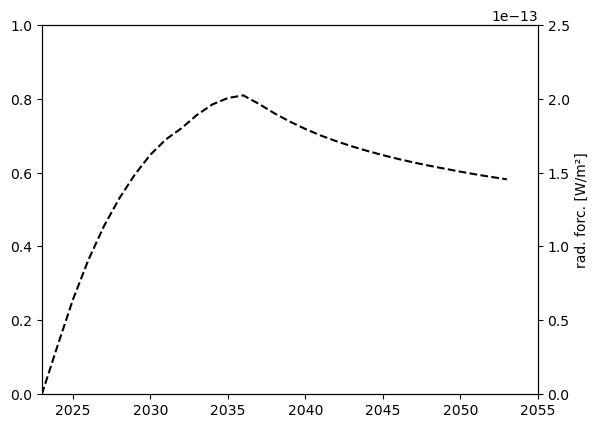

In [146]:
fig, ax = plt.subplots()
#c = 0
#res = {}
ax = ax.twinx()
ax.plot(anniRF, [sum(radiat[cap][n] for cap in radiat) for n in range(len(tempo))], 'k--', label = cap)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('rad. forc. [W/m²]')
plt.xlim(2023, 2055)
plt.ylim(0, 2.5e-13)
plt.show

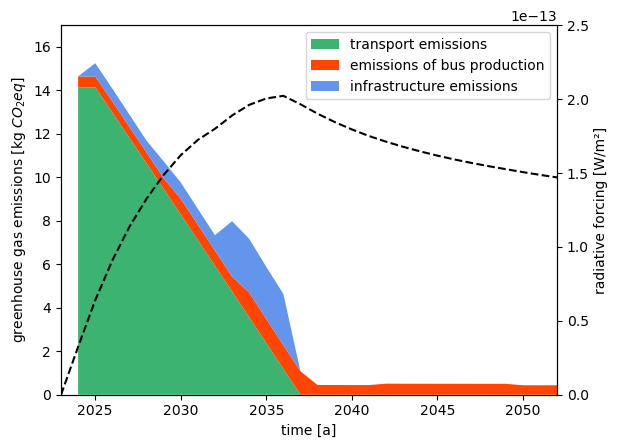

In [147]:
fig, ax1 = plt.subplots()
dct_color = {'transport emissions': 'mediumseagreen', 'emissions of bus production': 'orangered', 'infrastructure emissions': 'cornflowerblue', 'd': 'yellow'}
c = 0
ax1.stackplot(anni, trans, prod, powe, labels=['transport emissions', 'emissions of bus production', 'infrastructure emissions'], colors=[dct_color.get(l) for l in ['transport emissions', 'emissions of bus production', 'infrastructure emissions']])
#plt.xlim(np.datetime64('2024-01-01', 'Y'), np.datetime64('2056-01-01', 'Y'))
plt.xlim(2023, 2055)
#plt.title('1 t steel production, scenario 4')
#plt.ylim(0, 2000)
ax2 = ax1.twinx()
ax2.plot(anniRF, [sum(radiat[cap][n] for cap in radiat) for n in range(len(tempo))], 'k--')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_ylabel('radiative forcing [W/m²]')
plt.xlim(2023, 2052)
ax2.set_ylim(0, 2.5e-13)
ax1.set_ylim(0, 17)
plt.show
ax1.legend()
#ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xlabel('time [a]')
ax1.set_ylabel('greenhouse gas emissions [kg $CO_2 eq$]')
plt.show()